# Outline of the sensitization data analysis

In this notebook we briefly go through the steps taken to perform the analysis on the sensitization dataset in the paper.

#### Requirements

We recommend creating a fresh python environment and installing the required libraries via
```
pip install -r requirements.txt
```

### 0. Imports

In [11]:
import scipy.io as sio
import numpy as np
import tensorly as tl
import pandas as pd
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt

from tensorly.decomposition import non_negative_parafac

import matcouply
from matcouply.decomposition import cmf_aoadmm, initialize_cmf
from matcouply.penalties import Parafac2,NonNegativity

from copy import deepcopy
import plot_funcs

### 1. Load the data and preprocessing

In [3]:
# Load the data
data = sio.loadmat("Sensitization/sensitization_data.mat", simplify_cells=True)[
            "data"
        ]

data = tl.transpose(data, (2, 1, 0))

In [4]:
# Preprocessing

# Scale data (if applicable)

def preprocess_centerscale(X, flag_scale=True, flag_center=True):
    """
    Preprocess a 3D array (subjects × time × metabolites):
    - Center across subjects (mode-1)
    - Scale within each metabolite (mode-3) using RMS
    - Handles NaNs

    Parameters:
    - X: np.ndarray, shape (subjects, time, metabolites)
    - flag_scale: bool, whether to apply RMS scaling
    - flag_center: bool, whether to apply centering

    Returns:
    - Xpre: np.ndarray, preprocessed version of X
    """
    Xpre = np.copy(X)

    if flag_center:
        mean_subjects = np.nanmean(Xpre, axis=0)
        for i in range(Xpre.shape[0]):
            Xpre[i, :, :] = Xpre[i, :, :] - mean_subjects

    if flag_scale:
        for k in range(Xpre.shape[2]):
            rms = np.sqrt(np.nanmean(Xpre[:, :, k] ** 2))
            if rms != 0:
                Xpre[:, :, k] /= rms
            else:
                Xpre[:, :, k] = 0

    return Xpre

# data = preprocess_centerscale(data, flag_scale=True, flag_center=False)

# Normalize data

data = data / tl.norm(data)

### 2. Reproducibility and replicability analysis

In [ ]:
# Check uniqueness

# CMF

# %run uniqueness_check.py cmf 2 0 -s
# %run uniqueness_check.py cmf 3 0 -s
# %run uniqueness_check.py cmf 4 0 -s
# %run uniqueness_check.py cmf 5 0 -s
# %run uniqueness_check.py cmf 6 0 -s

# PARAFAC2

# %run uniqueness_check.py parafac2 2 0 -s
# %run uniqueness_check.py parafac2 3 0 -s
# %run uniqueness_check.py parafac2 4 0 -s
# %run uniqueness_check.py parafac2 5 0 -s
# %run uniqueness_check.py parafac2 6 0 -s

# CP

# %run uniqueness_check.py cp 2 0 -s
# %run uniqueness_check.py cp 3 0 -s
# %run uniqueness_check.py cp 4 0 -s
# %run uniqueness_check.py cp 5 0 -s
# %run uniqueness_check.py cp 6 0 -s

In [ ]:
# Check replicability

# CMF

# %run replicability_check.py cmf 2 0 -s
# %run replicability_check.py cmf 3 0 -s
# %run replicability_check.py cmf 4 0 -s
# %run replicability_check.py cmf 5 0 -s
# %run replicability_check.py cmf 6 0 -s

# PARAFAC2

# %run replicability_check.py parafac2 2 0 -s
# %run replicability_check.py parafac2 3 0 -s
# %run replicability_check.py parafac2 4 0 -s
# %run replicability_check.py parafac2 5 0 -s
# %run replicability_check.py parafac2 6 0 -s

# CP

# %run replicability_check.py cp 2 0 -s
# %run replicability_check.py cp 3 0 -s
# %run replicability_check.py cp 4 0 -s
# %run replicability_check.py cp 5 0 -s
# %run replicability_check.py cp 6 0 -s

The output of these scripts is located at `Sensitization/results/uniqueness/` and `Sensitization/results/replicability/`, respectively. The results can be nicely summarized in a plot by `uniqueness_analysis_sensitization.ipynb` and `replicability_analysis_sensitization.ipynb`. To reproduce the exact plot of the paper `paper_plots.ipynb` can be used.

### 3. Model fitting

In [ ]:
# Fitting CP models

# 😌 This one is runs actually pretty quick.

best_cp_error = np.inf
best_cp_factors = None

for init in tqdm.tqdm(range(2)):

    factors, errors = non_negative_parafac(
        tensor=data.T,
        tol=1e-6,
        rank=5,
        return_errors=True,
        n_iter_max=15000,
    )

    if len(errors) < 14990: # If we have not reached max number of iters
        if errors[-1] < best_cp_error: # did we get a better loss?
            best_cp_error = errors[-1]
            best_cp_factors = factors[1]

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Fitting PARAFAC2

# ⚠️ This might take significant amount of time (> 1hr).

best_parafac2_error = np.inf
best_parafac2_factors = None

for init in tqdm.tqdm(range(2)):

    (weights, (D, B, A)), run_diagnostics = cmf_aoadmm(
        matrices=data.T, # This needs to be transposed due to ordering of factors in matcouply
        rank=5,
        return_errors=True,
        n_iter_max=15000,
        regs=[
            [NonNegativity()],
            [NonNegativity(), Parafac2()],
            [NonNegativity()],
        ],
        tol=1e-8,
        inner_n_iter_max=20,
        absolute_tol=1e-6,
        feasibility_tol=1e-5,
        inner_tol=1e-5,
    )

    if (
        len(run_diagnostics.regularized_loss) > 14990
    ):
        continue
    else:
        if run_diagnostics.regularized_loss[-1] < best_parafac2_error:
            best_parafac2_error = run_diagnostics.regularized_loss[-1]
            best_parafac2_factors = (D, B, A)

In [ ]:
# Fitting CMF models

# ⚠️ This might take significant amount of time (> 1hr).

best_cmf_error = np.inf
best_cmf_factors = None

for init in tqdm.tqdm(range(2)):

    weights, (A_init, B_init, D_init) = initialize_cmf(
        matrices=data.T,
        rank=5,
        init="random",
        svd_fun="truncated_svd",
    )

    A_init = np.ones_like(A_init)
    cmf_init = weights, (A_init, B_init, D_init)

    (weights, (D, B, A)), run_diagnostics = cmf_aoadmm(
        matrices=data.T, # This needs to be transposed due to ordering of factors in matcouply
        rank=5,
        return_errors=True,
        n_iter_max=8000,
        regs=[[NonNegativity()], [NonNegativity()], [NonNegativity()]],
        tol=1e-8,
        init=cmf_init,
        update_A=False,
        inner_n_iter_max=20,
        absolute_tol=1e-6,
        feasibility_tol=1e-5,
        inner_tol=1e-5,
    )

    if (
        len(run_diagnostics.regularized_loss) > 7990
    ):
        continue
    else:
        if run_diagnostics.regularized_loss[-1] < best_cmf_error:
            best_cmf_error = run_diagnostics.regularized_loss[-1]
            best_cmf_factors = (D, B, A)

### 4. Plot results

In [12]:
# Import metadata
df = pd.read_csv('Sensitization/metadata_safe.csv')
meta = df['Delivery(Natural(1)/C-section(2)/Vacuum(3))'].to_numpy()
allergens = ['Mugwort','Birch','Molds','Timothy grass','Wheat flour', 'Milk','Peanut','Egg','Dog','Cat','D.pteronyssinus']
allergens.reverse()

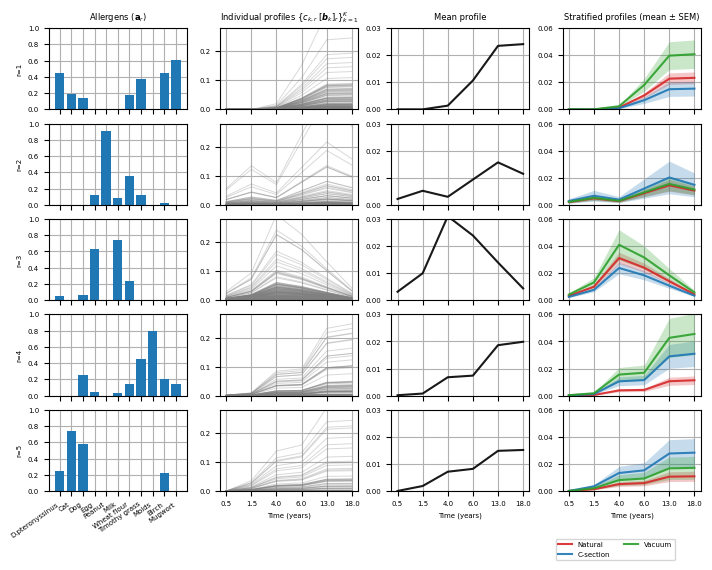

In [16]:
model = 'cp' # can be 'cmf', 'cp' or 'parafac2'
n_components = 5

######################################################

if model == 'cp':
    best_factors = best_cp_factors
    A = best_factors[2]
    C = best_factors[0]
    B = [deepcopy(best_factors[1]) for _ in range(C.shape[0])]
else:
    if model == 'parafac2':
        best_factors = best_parafac2_factors
        B = best_factors[1]
        A = best_factors[2]
        C = best_factors[0]
    elif model == 'cmf':
        best_factors = best_cmf_factors
        B = best_factors[1]
        A = best_factors[2]
        C = best_factors[0]



fig, axs = plt.subplots(
    5, 4,
    figsize=(8,0.65 * 8),
    constrained_layout=False
)

fig.subplots_adjust(
    left=0.06, right=0.875, bottom=0.08, top=0.97,
    wspace=0.24, hspace=0.175
)

for i, comp in enumerate(range(n_components)): # same order as in the paper
    if i == 0: 
        plot_funcs.plot_allergens_component(factors=(A,B,C),comp=comp, allergens=allergens, axes=axs[i,0],plot_title=True,comp_i=i)
        plot_funcs.plot_sensitization_profiles_component(factors=(A,B,C),comp=comp,axes=axs[i,1],comp_i=i,plot_title=True,time_points=[ 0.5,  1.5,  4. ,  6. , 13. , 18. ])
        plot_funcs.plot_sensitization_mean_profile_component(factors=(A,B,C),comp=comp,axes=axs[i,2],plot_title=True,time_points=[ 0.5,  1.5,  4. ,  6. , 13. , 18. ])
        plot_funcs.plot_sensitization_profiles_stratified_component(factors=(A,B,C),comp=comp,axes=axs[i,3],meta=meta,plot_title=True,time_points=[ 0.5,  1.5,  4. ,  6. , 13. , 18. ])
    elif i == 4: 
        plot_funcs.plot_allergens_component(factors=(A,B,C),comp=comp,allergens=allergens,axes=axs[i,0],plot_xticks=True,plot_legend=True,comp_i=i)
        plot_funcs.plot_sensitization_profiles_component(factors=(A,B,C),comp=comp,axes=axs[i,1],comp_i=i,plot_legend=True,plot_xticks=True,time_points=[ 0.5,  1.5,  4. ,  6. , 13. , 18. ])
        plot_funcs.plot_sensitization_mean_profile_component(factors=(A,B,C),comp=comp,axes=axs[i,2],plot_legend=True,plot_xticks=True,time_points=[ 0.5,  1.5,  4. ,  6. , 13. , 18. ])
        plot_funcs.plot_sensitization_profiles_stratified_component(factors=(A,B,C),meta=meta,comp=comp,axes=axs[i,3],plot_legend=True,plot_xticks=True,time_points=[ 0.5,  1.5,  4. ,  6. , 13. , 18. ])
    else: 
        plot_funcs.plot_allergens_component(factors=(A,B,C),comp=comp,allergens=allergens,axes=axs[i,0],comp_i=i)
        plot_funcs.plot_sensitization_profiles_component(factors=(A,B,C),comp=comp,axes=axs[i,1],comp_i=i,time_points=[ 0.5,  1.5,  4. ,  6. , 13. , 18. ])
        plot_funcs.plot_sensitization_mean_profile_component(factors=(A,B,C),comp=comp,axes=axs[i,2],plot_legend=True,plot_xticks=True,time_points=[ 0.5,  1.5,  4. ,  6. , 13. , 18. ])
        plot_funcs.plot_sensitization_profiles_stratified_component(factors=(A,B,C),meta=meta,comp=comp,axes=axs[i,3],time_points=[ 0.5,  1.5,  4. ,  6. , 13. , 18. ])

for ax in fig.axes:
    # Tick labels
    ax.tick_params(axis="both", which="both", labelsize=5)

    # Axes title + axis labels
    ax.title.set_fontsize(6)
    ax.xaxis.label.set_fontsize(5)
    ax.yaxis.label.set_fontsize(5)

    leg = ax.get_legend()
    if leg is not None:
        for t in leg.get_texts():
            t.set_fontsize(5)
        if leg.get_title() is not None:
            leg.get_title().set_fontsize(5)


axs[0,2].set_xticklabels([])
axs[1,2].set_xticklabels([])
axs[2,2].set_xticklabels([])
axs[3,2].set_xticklabels([])

plt.show()